# Probabilistic DRT fitting and analysis
This tutorial illustrates how to fit EIS data using the conventional DRT, the probability function of relaxation times (PFRT), and the dual regression-classification inversion algorithm. This is based on the probabilistic DRT interpretation described in [this work](https://www.cell.com/joule/fulltext/S2542-4351(24)00203-4). All of the fitting methods are accessed through the `DRT` class. To demonstrate the utility of the methods, we use a simulated spectrum for which the exact DRT is known *a priori*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from copy import deepcopy

from hybdrt.models import DRT
from hybdrt.models import elements
import hybdrt.plotting as hplt

%load_ext autoreload
%autoreload 2

# Simulate data
First, let's simulate some noisy data from an equivalent circuit analog consisting of 3 Havriliak-Negami (HN) elements in series with an ohmic resistance and inductance. The exact DRT of the circuit has two strongly overlapping peaks at $10^{-2}$ s and $10^{-1}$ s. In addition, the data is simulated with a substantial amount of noise, making separation of the two peaks very challenging.

In [2]:
# Noise generation
# --------------------------
def generate_noise(z_exact, rp, sigma_rel, structure, seed, uniform_frac=0.1):
    """
    Generate noise and error structure given exact impedance
    """
    rng = np.random.default_rng(seed)
    
    if structure == 'uniform':
        sigma_z = np.ones(len(z_exact)) * sigma_rel * rp * (1 + 1j)
    elif structure == 'modulus':
        z_mod = np.sqrt(np.real(z_exact * z_exact.conjugate()))
        sigma_z = sigma_rel * rp * z_mod * (1 + 1j) / np.mean(z_mod)
    elif structure == 'mixed':
        z_mod = np.sqrt(np.real(z_exact * z_exact.conjugate()))
        sigma_z = uniform_frac * sigma_rel * rp * (1 + 1j) 
        sigma_z += (1 - uniform_frac) * sigma_rel * rp * z_mod * (1 + 1j) / np.mean(z_mod)
        
    z_err = rng.normal(0, sigma_z.real) + 1j * rng.normal(0, sigma_z.imag)
    
    return sigma_z, z_err

def generate_noisy_data(f, model, sigma_rel, structure, seed, uniform_frac=0.1):
    """
    Generate noisy data from a model
    """
    z_exact = model.predict_z(f)
    rp = model.predict_r_p()
    sigma_z, z_err = generate_noise(z_exact, rp, sigma_rel, structure, seed, uniform_frac)
    
    return z_exact + z_err, sigma_z

<Axes: xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>

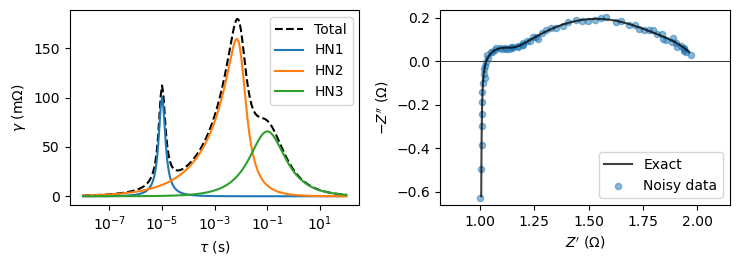

In [3]:
# Define model
# 3-HN
model = elements.DiscreteElementModel('R0-L0-HN1-HN2-HN3')
model_params = np.array(
    [
        1, np.log(1e-7),  # R0, L0
        0.1, np.log(1e-5), 1, 0.9,  # HN1
        0.6, np.log(1e-2), 0.5, 0.8,  # HN2
        0.3, np.log(1e-1), 1, 0.6  # HN3
    ]
)
model.parameter_values = model_params

# Simulate data
freq = np.logspace(6, -1, 71)
z_true = model.predict_z(freq)
rng = np.random.default_rng(834)
for i in range(4):  # iterate to match seed used for paper
    z_noisy, sigma_z = generate_noisy_data(freq, model, 5e-3, 'mixed', rng.integers(int(1e6)))
    
    
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.75))

# Plot exact DRT
tau_plot = np.logspace(-8, 2, 201)
model.plot_drt(tau_plot, ax=axes[0], ls="--", c="k", label="Total")
# Plot individual DRT of each circuit element
model.plot_element_drts(tau_plot, ax=axes[0], kw_list=[{"label": f"HN{i + 1}"} for i in range(3)])
axes[0].legend()

# Plot exact impedance
hplt.plot_nyquist((freq, z_true), plot_func='plot', c='k', label='Exact', alpha=0.75, ax=axes[1])

# Plot noisy data
hplt.plot_nyquist((freq, z_noisy), label='Noisy data', ax=axes[1])

# Baseline DRT fit
We can first fit the noisy data with a conventional DRT algorithm. The baseline DRT algorithm provided by `hybrid-drt` (`DRT.fit_eis`) uses an efficient, self-tuning hierarchical Bayesian model that is effective for recovering a variety of peak shapes while suppressing false peaks.

Note that by default, when a `DRT` instance is created, it will generate a set of interpolation grids that allow the matrices required for inversion to be calculated nearly instantaneously. Generating the grids takes only a second or two, and they can be re-used for all later fits performed with the same instance. To disable this behavior, you can specify `interpolate_integrals=False` at instantiation to force numerical evaluation of the matrices (but this is virtually always slower).

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


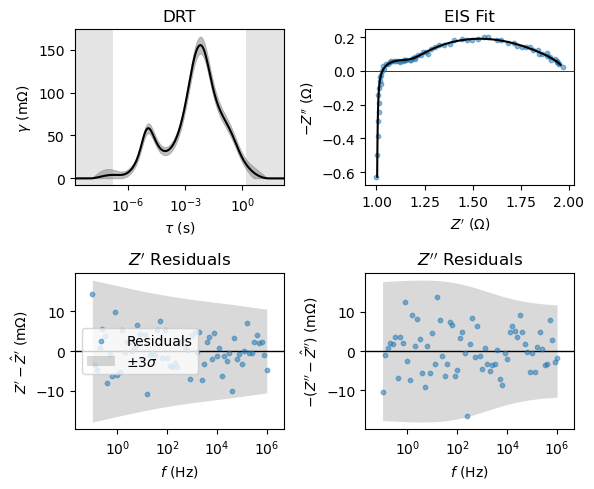

In [4]:
# Create a DRT instance
drt = DRT()

# Fit the data
drt.fit_eis(freq, z_noisy)

# Plot the results
axes = drt.plot_results()

The `plot_results` method shows a summary set of diagnostic plots. The top left panel shows the estimated DRT with the 95% credible interval, the top right panel shows a Nyquist plot of the fit of the data, and the two bottom panels show the real and imaginary residuals with the estimated error structure of the data overlaid. The DRT estimate indicates that at least two peaks at $10^{-3}$ and $10^{-2}$ are present, but it is very difficult to tell if the shoulder peaks at $10^{-7}$ s and $10^{-1}$ s are real, distinct peaks. This is the inherent ambiguity of analyzing DRT results: we can't tell with certainty which peaks are real and which are erroneous (i.e. induced by noise or the regularization scheme).

Comparing the baseline DRT estimate to the exact DRT (corresponding to the equivalent circuit from which the data were simulated), we find that the baseline estimate matches the true DRT reasonably well. However, using local minima in the curvature to identify peaks in the estimated DRT suggests an erroneous peak at $10^{-7}$ s, while the real peak at $10^{-1}$ s is not clearly resolved.

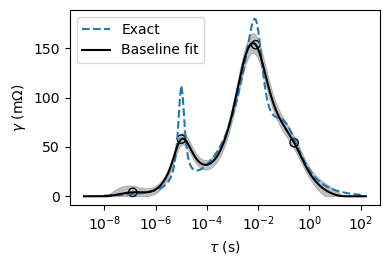

In [5]:
fig, ax = plt.subplots(figsize=(4, 2.75))

model.plot_drt(tau_plot, ax=ax, label='Exact', ls='--')

drt.plot_drt(ax=ax, c='k', plot_ci=True, label='Baseline fit', 
                      mark_peaks=True, 
                      mark_peaks_kw={'edgecolors': 'k', 'facecolors': 'none'})

ax.legend()

# Probability function of relaxation times (PFRT) fit
The PFRT is designed to complement the DRT and clarify its interpretation. The PFRT is the classification-centric analog of the DRT: whereas the DRT estimates the magnitude of the distribution as a function of $\ln{\tau}$ (regression), the PFRT estimates the *probabiliity that a peak exists in the DRT* at each $\ln{\tau}$. We can apply the PFRT to the same dataset.

In [6]:
# Copy the DRT object to re-use the integral lookups
drt_pf = deepcopy(drt)

# Perform a PFRT fit
drt_pf.pfrt_fit_eis(freq, z_noisy)

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:1361: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


The PFRT operates by calculating many different DRT estimates using varying regularization strengths. We can then examine the generated DRT estimates to determine where peaks consistently appear, which provides a semi-quantitative indication of how likely it is that each peak represents a real physical phenomenon.

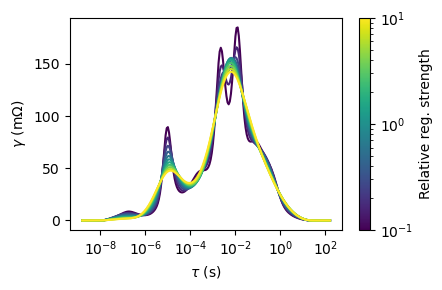

In [7]:
# Visualize the generated DRT estimates
factors = drt_pf.pfrt_result['factors']
reg_strength = factors ** -1
est_x = drt_pf.pfrt_result['step_x']


cmap = mpl.colormaps['viridis']
norm = mpl.colors.LogNorm(vmin=reg_strength[-1], vmax=reg_strength[0])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(figsize=(4.5, 3))
for strength, x in zip(reg_strength[::-1], est_x[::-1]):
    drt_pf.plot_drt(x=x, ax=ax, c=cmap(norm(strength)))
    
plt.colorbar(sm, ax=ax, label='Relative reg. strength')

fig.tight_layout()

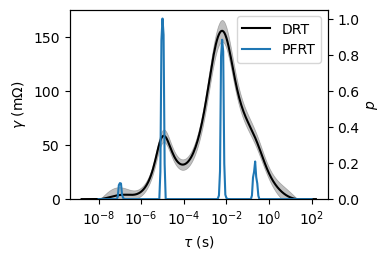

In [8]:
# Calculate the PFRT from the fit results
pf = drt_pf.predict_pfrt(tau_plot)

fig, ax = plt.subplots(figsize=(4, 2.75))
# Plot the PFRT against the baseline DRT
ax, lines = drt.plot_drt(c='k', plot_ci=True, label='DRT', return_line=True, ax=ax)
ax2 = ax.twinx()
ln2 = ax2.plot(tau_plot, pf, label='PFRT')

ax.set_ylim(0, 175)
ax2.set_ylim(0, 1.05)
ax2.set_ylabel('$p$')

ax.legend(handles=[lines[0][0], ln2[0]], labels=['DRT', 'PFRT'])


fig = ax.get_figure()
fig.tight_layout()

The PFRT tells us that the two primary peaks in the DRT are certain to exist, but indicates relatively weak evidence for the peak at $10^{-1}$ s, while the peak at $10^{-7}$ s is most likely erroneous. However, the PFRT (as currently implemented) is a semi-quantitative tool - it provides a ranking of the plausibilities of different peaks, but may not accurately quantify the evidence for existence of any given peak. This is because the PFRT calculation still relies on continuous DRT estimates that are inherently biased by smoothing regularization. To release this constraint, we must consider discrete models for the data using the dual inversion algorithm.

# Dual regression-classification inversion

The dual regression-classification inversion algorithm uses both continuous (conventional DRT) models and discrete (equivalent circuit) models to analyze the data. Briefly, the dual algorithm uses many DRT fits to generate a set of candidate discrete models for the data, and then evaluates the plausibility of each discrete model. In this way, we can (a) consider several different discrete models, each of which represents a different interpretation of the data, and (b) use rigorous statistical criteria to evaluate and select an appropriate model or models. By default, discrete models are constructed using HN elements for their versatility, but other elements can be employed.

In [9]:
# Make a copy of the instance to re-use integral lookups
dual = deepcopy(drt)

# Perform a dual fit
dual.dual_fit_eis(freq, z_noisy, discrete_kw=dict(prior=True, prior_strength=None))
# Commented code below uses RQ elements instead of HN elements to construct the discrete models
# dual.dual_fit_eis(freq, z_noisy, discrete_kw=dict(prior=True, prior_strength=None, model_init_kw=dict(drt_element="RQ")))

fill_index: []


C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\elements.py:1333: UserWarning: Determinant of precision matrix is negative. This may indicate a suboptimal solution. Check the fit and LML
  warnings.warn('Determinant of precision matrix is negative. This may indicate a suboptimal '


The dual algorithm generates a set of discrete candidates. These candidates are summarized in the `discrete_candidate_df` DataFrame, which lists candidates by the number of discrete elements (peaks) that they contain. The plausibility of the candidates is evaluated by three different criteria: the Bayesian information criterion (BIC), the approximate log-marginal-likelihood (LML), and a combination of both (LML-BIC). Smaller BIC values indicate greater plausibility, while higher LML values indicate greater plausibility. The `rel_<criterion>` columns indicate criteria values relative to the best value for each criterion, such that the most plausible candidate as determined by each criterion will have a `rel_<criterion>` value of zero. In the DataFrame shown below, the BIC and LML-BIC indicate that the 3-peak model is most plausible, while the LML suggests that the 2- and 3-peak models are both highly plausible.

In [10]:
dual.discrete_candidate_df

,model_id,num_peaks,llh,bic,lml,lml-bic,rel_llh,rel_bic,rel_lml,rel_lml-bic
0,2.0,2.0,672.861034,-1303.095269,616.700241,634.123938,-20.123990,5.796125,0.000000,-1.395671
1,3.0,3.0,684.284456,-1308.891394,616.593520,635.519609,-8.700568,0.000000,-0.106721,0.000000
2,4.0,4.0,686.216496,-1295.704755,605.238826,626.545602,-6.768528,13.186640,-11.461414,-8.974007
3,5.0,5.0,688.230400,-1282.681843,592.015164,616.678043,-4.754624,26.209551,-24.685076,-18.841566
4,6.0,6.0,691.202076,-1271.574476,583.830769,609.809003,-1.782947,37.316918,-32.869472,-25.710605
5,7.0,7.0,692.821231,-1257.762067,574.004544,601.442788,-0.163792,51.129328,-42.695697,-34.076820
6,8.0,8.0,692.985024,-1241.038932,560.936825,590.728145,0.000000,67.852462,-55.763416,-44.791463


The model plausibilities may also be visualized with the `plot_norm_bayes_factors` method, which plots the normalized Bayes factor ($B_Q$) as a function of the number of model peaks ($Q$). The $B_Q$ value is a direct quantification of plausibility: the most plausible model receives a value of 1, and all other models are quantified relative to that model.

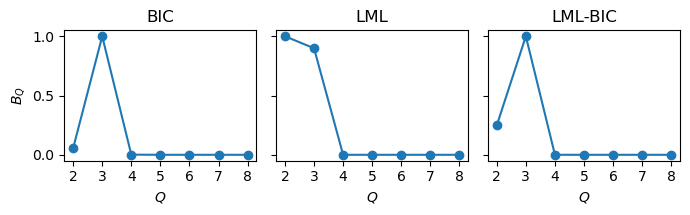

In [11]:
# Plot normalized Bayes factors for each model
fig, axes = plt.subplots(1, 3, figsize=(7, 2.25), sharex=True, sharey=True)
for i, crit in enumerate(['bic', 'lml', 'lml-bic']):
    dual.plot_norm_bayes_factors('discrete', criterion=crit, marker='o', ax=axes[i])
    axes[i].set_title(crit.upper())
    
    if i > 0:
        axes[i].set_ylabel('')
        
fig.tight_layout()

If we plot the three most plausible discrete candidates identified by the algorithm ($2 \leq Q \leq 4$), we see that they correspond well to both the DRT and the PFRT. The two-peak model captures the two clearly resolved peaks, the three-peak model captures all three real peaks, and the four-peak model adds the pseudo-peak at $10^{-7}$ s. The model selection criteria above tell us that the three-peak model is the most plausible model; the two-peak model is not entirely unreasonable, but the four-peak model is strongly rejected. 

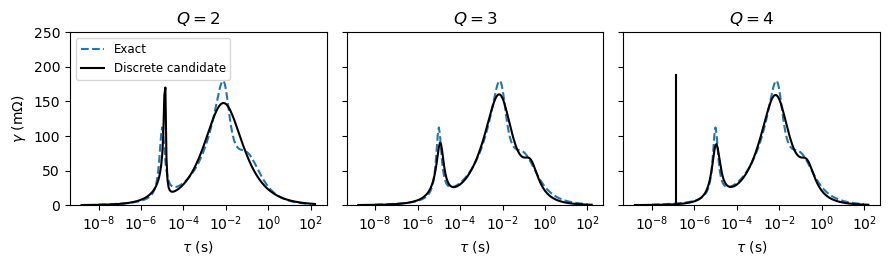

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.75), sharex=True, sharey=True)

for i, q in enumerate([2, 3, 4]):
    ax = axes[i]
    
    # Plot true DRT
    model.plot_drt(tau_plot, ax=ax, ls='--', label='Exact')
    
    # Plot discrete model DRT
    dual.plot_candidate_drt(q, 'discrete', c='k', ax=ax, label='Discrete candidate')
    
    if i > 0:
        ax.set_ylabel('')
        
    ax.set_title(f'$Q={q}$')
        
axes[0].set_ylim(0, 250)
axes[0].legend(loc='upper left', fontsize=8.5)
        
fig.tight_layout()

The most plausible 3-peak model matches the true DRT very closely and identifies all three peak locations accurately. Thus, with this approach, we're able to very quickly identify and optimize possible models, select the most appropriate models, and quantify uncertainty in model selection and peak existence.

# Visualizing, analyzing, and accessing results
The sections above provide a quick introduction to the core EIS fitting functionality. This section illustrates additional functionality for visualizing results, accessing fit parameters, and further analysis.

## Visualization
The methods `plot_drt`, `plot_eis_fit`, and `plot_eis_residuals` are available for customizable axis-level plotting. Keyword arguments may be passed to the underlying `matplotlib` functions.

<Axes: xlabel='$\\tau$ (s)', ylabel='$\\gamma \\, / \\, R_p$'>

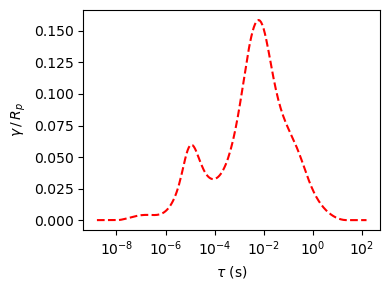

In [13]:
# plot_drt with keyword args, normalized to polarization resistance
drt.plot_drt(normalize=True, c='r', ls='--')

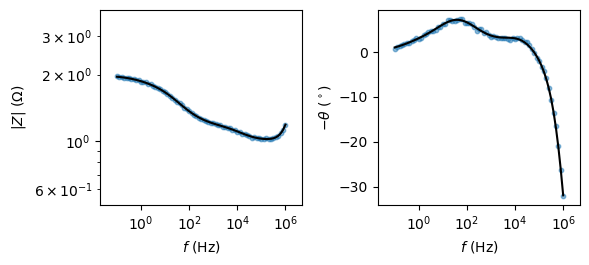

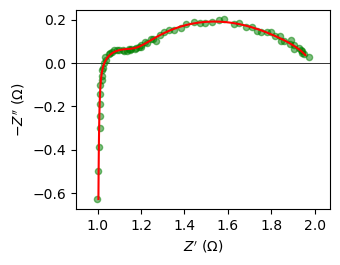

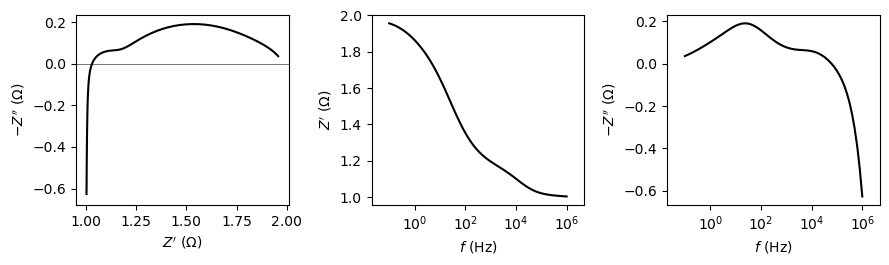

In [14]:
# plot_eis_fit with axis specification and different plot types

# Bode plots of phase and modulus
bode_axes = drt.plot_eis_fit(plot_type='bode', bode_rep="polar")

# Nyquist plot with keyword args for data and fit line
nyq_ax = drt.plot_eis_fit(plot_type='nyquist',  c='r', data_kw={'c': 'green'})

# Nyquist and Bode plots (real and imag) without data points
combo_axes = drt.plot_eis_fit(plot_type='all', plot_data=False)



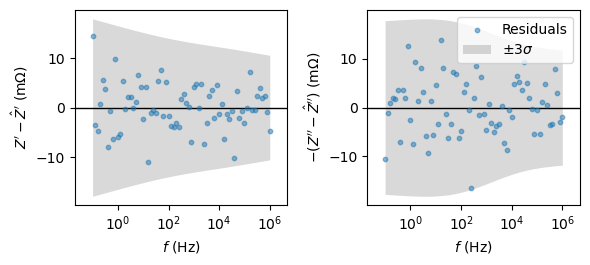

In [15]:
# Real and imaginary impedance residuals with estimated +/- 3 sigma range
axes = drt.plot_eis_residuals()
axes[1].legend(loc="upper right")

## Analyzing peaks
You can analyze peaks in a conventional DRT fit without creating discrete models through `dual_fit_eis`. A fitted `DRT` instance can identify peaks in the estimated distribution using local minima in the curvature. You may need to tweak the `prominence` and/or `height` arguments to obtain the desired results, but the default parameters are usually a good starting point.

In [16]:
# Default parameters
print('Peaks found with default settings:\n', drt.find_peaks())
print('Peaks found with higher prominence threshold:\n', drt.find_peaks(prominence=1e-2))

Peaks found with default settings:
 [1.26421265e-07 1.00419980e-05 7.97664256e-03 2.52243586e-01]
Peaks found with higher prominence threshold:
 [1.00419980e-05 7.97664256e-03 2.52243586e-01]


Peak locations can be visualized easily with `plot_drt` and/or `mark_peaks`.

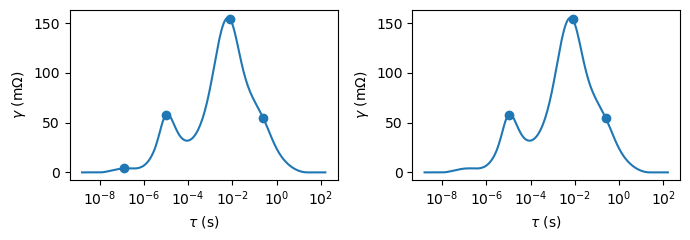

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))

# Default settings
drt.plot_drt(ax=axes[0], mark_peaks=True)

# Higher threshold passed to mark_peaks
drt.plot_drt(ax=axes[1])
drt.mark_peaks(find_peaks_kw=dict(prominence=1e-2), ax=axes[1])

### Separating and quantifying peaks
Finally, you can attempt to separate and quantify distinct peaks in a DRT estimate using `estimate_peak_drts`, `plot_peak_drts`, and `quantify_peaks`. The procedure works by identifying peaks using the curvature as shown above, identifying troughs between peaks, and then applying local weighting functions around each identified peak to estimate the distribution of each individual peak. This is not a fool-proof method, and it makes no assumptions about the shapes of the peaks, so be sure to verify the results.

*NOTE*: if you want quantitative parameters for well-defined peak shapes (like RQ/ZARC or Havriliak-Negami peaks), use the dual regression-classification fit described above, and then access the resulting fit parameters as shown in the final section below.

In [18]:
# Estimate the individual peak distributions
peak_gammas = drt.estimate_peak_drts(tau_plot)
peak_gammas.shape  # There are 4 peaks, each of which is distributed over the tau_plot grid

(4, 201)

<Axes: xlabel='$\\tau$ (s)', ylabel='$\\gamma$ (m$\\Omega$)'>

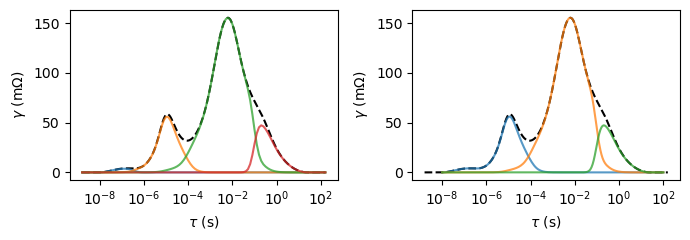

In [19]:
# Plot the individual peak distributions over the total distribution
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))

# Default peak identification settings
drt.plot_drt(c='k', ls='--', ax=axes[0])
drt.plot_peak_drts(ax=axes[0], alpha=0.75)

# Higher threshold
drt.plot_drt(c='k', ls='--', ax=axes[1])
peak_gammas = drt.estimate_peak_drts(tau_plot, find_peaks_kw=dict(prominence=1e-2))
drt.plot_peak_drts(tau=tau_plot, ax=axes[1], peak_gammas=peak_gammas, alpha=0.75)

Notice that in the plot on the right, we set a higher peak prominence threshold that removed the identified peak at $10^{-7}$ s. As a result, the estimated distribution of the first peak on the left has a very long tail. This shows how the procedure for separating peaks may yield unusual peak shapes depending on the parameters selected.

Finally, we can quantify the area (total resistance) of each peak with `quantify_peaks`.

In [20]:
# Quantify individual peak areas in ohms
drt.quantify_peaks()

[np.float64(0.00854488726408342),
 np.float64(0.1581932796087981),
 np.float64(0.6916735567814367),
 np.float64(0.12122861313658155)]

## Accessing fit parameters and quantities
This section shows how to access parameters and quantities resulting from a fit.

### Conventional DRT fit

In [21]:
# Access the fit parameters
drt.fit_parameters

{'x': array([0.00019874, 0.00041775, 0.00069699, 0.00098508, 0.00127749,
        0.00155336, 0.00180174, 0.0020093 , 0.00216608, 0.00226478,
        0.00230431, 0.00229261, 0.00224983, 0.00220968, 0.00221841,
        0.00233105, 0.00260575, 0.00309815, 0.00385803, 0.0049305 ,
        0.00636303, 0.00821776, 0.01058845, 0.01361917, 0.01747668,
        0.02213164, 0.02700166, 0.03101173, 0.03321168, 0.03328916,
        0.03160234, 0.02888696, 0.02589884, 0.02317529, 0.02098151,
        0.01938761, 0.01837268, 0.01789392, 0.01791649, 0.01842183,
        0.01940827, 0.02088956, 0.02289336, 0.0254588 , 0.02863303,
        0.03246775, 0.03701578, 0.04231712, 0.04836101, 0.0550291 ,
        0.06205095, 0.06900713, 0.07540005, 0.08077218, 0.08480078,
        0.08729458, 0.08811254, 0.08712343, 0.08429337, 0.07983642,
        0.07426128, 0.06823928, 0.062385  , 0.05710335, 0.0525589 ,
        0.0487345 , 0.04551335, 0.04274385, 0.04027294, 0.03795622,
        0.03565898, 0.03326137, 0.03067286,

In [22]:
# Evaluate the ohmic resistance, polarization resistance, and total resistance
print('R_inf: {:.2f} ohms'.format(drt.predict_r_inf()))
print('R_p: {:.2f} ohms'.format(drt.predict_r_p()))
print('R_tot: {:.2f} ohms'.format(drt.predict_r_tot()))

R_inf: 1.00 ohms
R_p: 0.98 ohms
R_tot: 1.98 ohms


In [23]:
# Evaluate the DRT over a specified tau grid
drt.predict_drt(tau_plot)

array([3.42962893e-06, 2.05664829e-05, 7.76648818e-05, 1.94847504e-04,
       3.58790561e-04, 5.48221003e-04, 7.57486875e-04, 9.86713902e-04,
       1.23124198e-03, 1.48279778e-03, 1.73848668e-03, 1.99424898e-03,
       2.24828021e-03, 2.49478490e-03, 2.73292814e-03, 2.95753250e-03,
       3.16852508e-03, 3.36027188e-03, 3.53349818e-03, 3.68283282e-03,
       3.80998992e-03, 3.91013638e-03, 3.98638309e-03, 4.03524836e-03,
       4.06177322e-03, 4.06462078e-03, 4.05126839e-03, 4.02326153e-03,
       3.99075887e-03, 3.95850325e-03, 3.93912578e-03, 3.94028454e-03,
       3.97637116e-03, 4.05703550e-03, 4.19738071e-03, 4.40769981e-03,
       4.70278059e-03, 5.09219433e-03, 5.58988706e-03, 6.20385405e-03,
       6.94763892e-03, 7.82779034e-03, 8.85912613e-03, 1.00480865e-02,
       1.14136441e-02, 1.29646166e-02, 1.47280307e-02, 1.67183768e-02,
       1.89745868e-02, 2.15174453e-02, 2.43928900e-02, 2.76101357e-02,
       3.11860038e-02, 3.50624571e-02, 3.91661199e-02, 4.33158560e-02,
      

In [24]:
# Evaluate the model impedance over a specified frequency array
drt.predict_z(freq)

array([1.00364953+0.62645302j, 1.00459875+0.4949494j ,
       1.00561764+0.39014193j, 1.00672457+0.30646466j,
       1.00794996+0.23948332j, 1.00933826+0.18566464j,
       1.01094921+0.14219431j, 1.01285842+0.10683403j,
       1.01515688+0.0778094j , 1.01794926+0.0537227j ,
       1.02135041+0.03348539j, 1.02547936+0.01626613j,
       1.03044988+0.00145005j, 1.03635708-0.01139478j,
       1.04326056-0.02254874j, 1.05116666-0.03217399j,
       1.06001436-0.04035248j, 1.06967044-0.0471278j ,
       1.07993815-0.05254629j, 1.09057966-0.05669038j,
       1.10134784-0.05969778j, 1.11201967-0.06176402j,
       1.12242349-0.06313045j, 1.13245498-0.06406347j,
       1.142081  -0.06483197j, 1.15133369-0.06568826j,
       1.16029899-0.06685547j, 1.16910372-0.06852133j,
       1.1779039 -0.070837j  , 1.18687585-0.0739187j ,
       1.19621009-0.0778501j , 1.2061074 -0.08268415j,
       1.21677614-0.08844331j, 1.22842966-0.09511802j,
       1.24128282-0.10266345j, 1.25554655-0.11099512j,
       1.2

### Dual fit
The `dual_fit_eis` method creates several `DiscreteElementModel` instances. You can access these model instances through the `DRT` instance and use them for further analysis.

<Axes: xlabel='$\\tau$ (s)', ylabel='$\\gamma$ (m$\\Omega$)'>

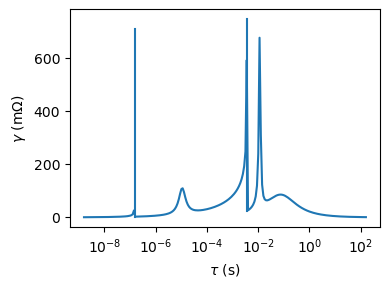

In [25]:
# Plot the 5-peak discrete candidate distribution
dual.plot_candidate_drt(5, 'discrete')

In [26]:
# Get the best discrete candidate identified by the dual algorithm
best_id = dual.get_best_candidate_id('discrete', criterion='bic')
best_model_dict = dual.get_candidate(best_id, 'discrete')
best_model_dict

{'model': <hybdrt.models.elements.DiscreteElementModel at 0x28b27a21520>,
 'llh': np.float64(684.2844563832584),
 'bic': np.float64(-1308.8913944879384),
 'lml': np.float64(616.5935197751254),
 'lml-bic': np.float64(635.5196085095473),
 'peak_tau': array([1.15297564e-05, 7.61763451e-03, 2.19694979e-01]),
 'time_constants': array([1.20325806e-05, 8.79820661e-03, 2.15053500e-01]),
 'rel_llh': np.float64(-8.700567521437279),
 'rel_bic': np.float64(0.0),
 'rel_lml': np.float64(-0.10672080571123388),
 'rel_lml-bic': np.float64(0.0)}

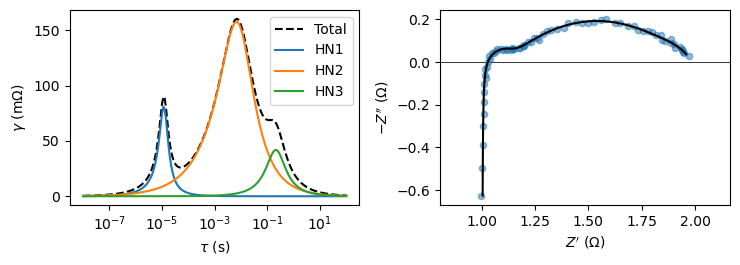

In [27]:
# Retrieve the best DiscreteElementModel instance and visualize
best_model = best_model_dict['model']

fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.75))

best_model.plot_drt(tau=tau_plot, ax=axes[0], c="k", ls="--", label="Total")
best_model.plot_element_drts(tau=tau_plot, ax=axes[0], kw_list=[{"label": f"HN{i + 1}"} for i in range(3)])

best_model.plot_eis_fit(axes=axes[1])

axes[0].legend()

In [28]:
# Return the discrete model parameters
# The full model contains a series ohmic resistance (R0 with resistance R_R0) and inductance (L0 with log-inductance lnL_L0) 
# Each HN element has 4 parameters: R, ln(tau), alpha, and beta
best_model.parameter_dict

{'R_R0': np.float64(1.0008246225009394),
 'lnL_L0': np.float64(-16.112048493878284),
 'R_HN1': np.float64(0.12044548714945387),
 'lntau_HN1': np.float64(-11.32789254050951),
 'alpha_HN1': np.float64(0.888618289459053),
 'beta_HN1': np.float64(0.8709895630629405),
 'R_HN2': np.float64(0.7467366625448789),
 'lntau_HN2': np.float64(-4.733207372334001),
 'alpha_HN2': np.float64(0.7725724005722439),
 'beta_HN2': np.float64(0.6334794161115398),
 'R_HN3': np.float64(0.11448803735888177),
 'lntau_HN3': np.float64(-1.5368684443393978),
 'alpha_HN3': np.float64(0.9672391814568122),
 'beta_HN3': np.float64(0.7445449415805987)}